In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d


import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

In [2]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-Library/NPGMI Update.ipynb"

### 3PGMI PRL Data

In [3]:
prld, prlcont = np.genfromtxt("PRLPOLYCONTDATA.csv",delimiter=",").T
prlfreq = np.genfromtxt("PRLFREQDATA.csv").T[1]
prlconterr = np.genfromtxt("PRLPOLYCONTERROR.csv",delimiter=",").T[1] - prlcont

### SEM Profile Processing 

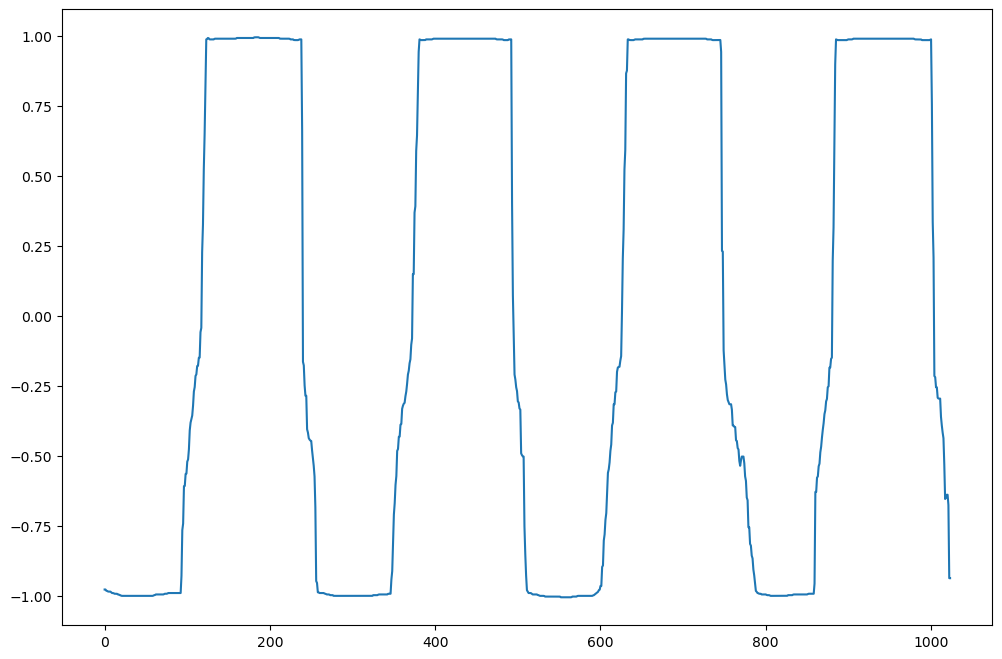

In [4]:


oldbbx,oldbbprofile = np.genfromtxt("oldbbprofile.csv", delimiter= ",")[:-2].T
n_periods = 4
uniquex, uniqueind = np.unique(oldbbx,return_index = True)
oldbbprofile = oldbbprofile[uniqueind]
oldbbsize = np.max(uniquex) - np.min(uniquex)

interpfuncbb = interp1d(uniquex, oldbbprofile)
bbx = np.linspace(np.min(uniquex), np.max(uniquex),1024)

bbprofile = interpfuncbb(bbx)
bbsize = np.max(bbx) - np.min(bbx)



# ftbb = np.abs(fft(exp(1j * phi2[19]/2 * bbprofile)))
# freqsbb = get_freqs(ftbb,bbsize)

# oldftbb = np.abs(fft(exp(1j * phi2[19]/2 * oldbbprofile)))
# oldfreqsbb = get_freqs(oldftbb,oldbbsize)

fig,ax1 = plt.subplots(figsize=(12,8))

# ax1.plot(oldbbprofile,"o-")
ax1.plot(bbprofile)


# ax1.plot(oldfreqsbb,oldftbb)
# ax1.plot(freqsbb,ftbb)
# ax1.set_xlim(-3e7,3e7)

plt.show()

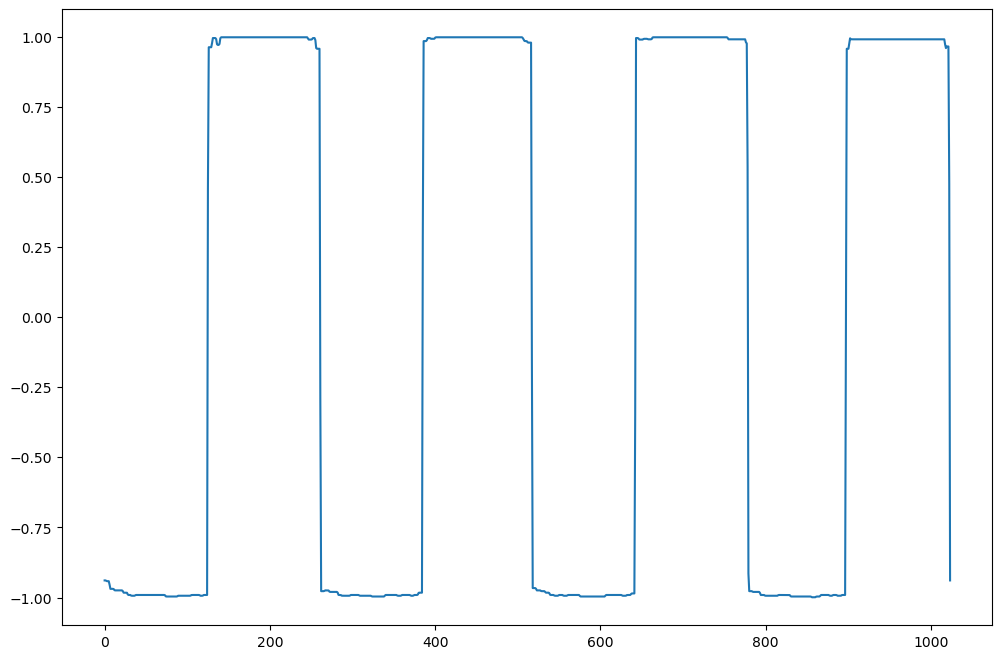

In [5]:
def smooth_profile(profile, pct_diff):
    for i in range(1,len(profile)-1):
        a,b,c = profile[i-1], profile[i], profile[i+1]
        if b != 0:
            if abs((b - a)/b) > (pct_diff/100.0) and abs((b- c)/b) > (pct_diff/100.0):
                profile[i] = (a+c)/2
    return profile

rx, rprofile = np.genfromtxt("rectprofile.csv", delimiter = ",")[:-1].T
rux, testind = np.unique(rx,return_index=True)
rprofile = smooth_profile(rprofile[testind],10)


rprofile[488:492] = 0.99
rprofile[560:576] = 0.99
rprofile[670:755] = 0.99


interpfuncr = interp1d(np.linspace(rux[0],rux[-1],len(rprofile)),rprofile)

rprofile = interpfuncr(np.linspace(rux[0],rux[-1],1024))

rsize = np.max(rux) - np.min(rux)


fig,ax1 = plt.subplots(figsize=(12,8))
ax1.plot(rprofile,"-")



# ftr = np.abs(fft(exp(1j*phi2[19]/2 * rprofile),norm = "forward"))
# freqsr = get_freqs(ftr,rsize)
# ax1.plot(freqsr,ftr)
# ax1.plot(freqsi, fti,label = "Ideal G(x)")
# plt.xlim(-3e7,3e7)


plt.show()
plt.close(fig)

### Rotation

In [293]:

t0 = time()
# bbdeg = np.arange(3,4.5,0.1)
bbdeg = np.array([4.4])
# rdeg = np.arange(3,4.75,0.25)
rdeg = np.array([3.5])




RotatedBB = RotatedProfile(bbdeg,bbprofile,bbsize,h2,p)
RotatedRect = RotatedProfile(rdeg,rprofile,rsize,h1,p)

rotbbprofiles = RotatedBB.rotated_profiles
rotrprofiles = RotatedRect.rotated_profiles

print(time() - t0, "seconds")




2.0269131660461426 seconds


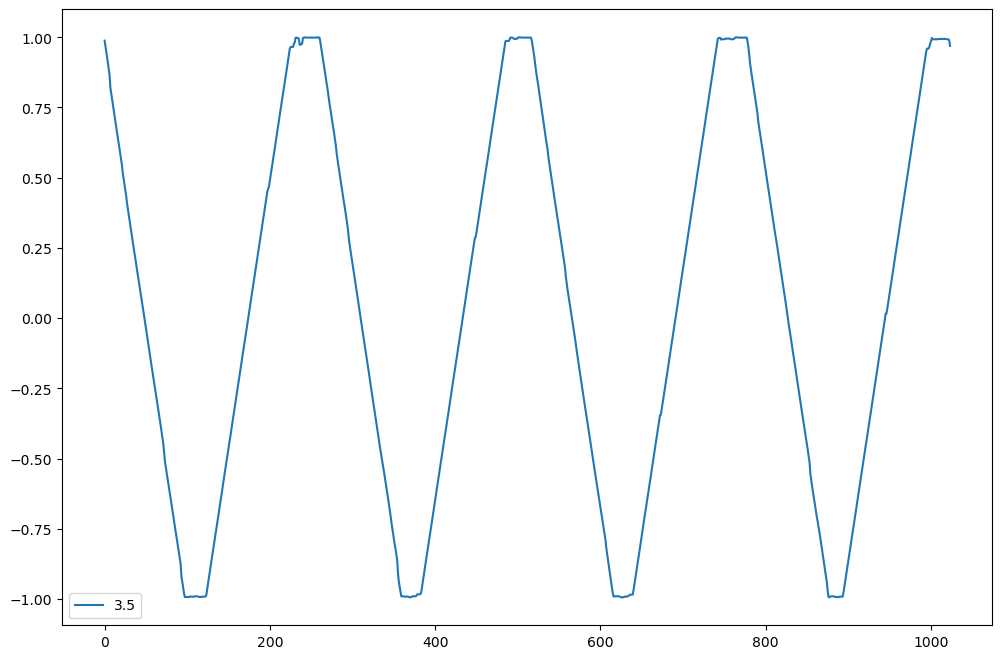

In [294]:



fig,ax = plt.subplots(figsize = (12,8))

# [ax.plot(rotbbprofiles[i], label = bbdeg[i]) for i,_ in enumerate(bbdeg)]
# ax.plot(rotbbprofiles[0])
[ax.plot(rotrprofiles[i], label = rdeg[i]) for i,_ in enumerate(rdeg)]

# ax.plot(rotrprofiles[1])
# plt.xlim(0,3000)



ax.legend()
plt.show()


plt.close(fig)

### Simulations

In [295]:

p = 2.4e-6
L = 8.8

lam = np.array([5e-10])
plam = np.array([1])

polyspectrum = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
polyspectrum[0]*=1e-9
lam,plam = polyspectrum.copy()

x0 = np.array([0])



mt = 5


Nbc = 5e28*4.149e-15
h1,h2,h3 = 15.8e-6,29e-6,15.8e-6

phi1,phi2,phi3 = Nbc*lam*h1,Nbc*lam*h2,Nbc*lam*h3
# phi1,phi2,phi3 = np.array([pi/2]),np.array([pi]),np.array([pi/2])
idealgrating_phase_offset = -413*pi/440


camsize = 2.5e-2
slitx = 500e-6
slity = 100e-6

xbin = 1e-6
ybin = 1e-6

res = 150e-6
d1 = np.array([4.5e-2])

# d1 = np.arange(4.1,4.8 + 0.05,0.05)*1e-2

L1 = 4.75
d3pgmi = np.linspace(2,7,102)*1e-2
d3pgmi, d1 = force_broadcast(d3pgmi, d1)

# G1sd = {"p":p, "L1": np.array([L1 - d1]), "phi":phi1, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}
G1sd = {"p":p,"image_profile":rotrprofiles[0], "real_length": rsize, "L1": np.array([L1 - d1]),
        "phi":phi1, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}

G1sd["L2"] = d1

# G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}
G2sd = {"p":p,"image_profile":rotbbprofiles[0], "real_length": bbsize, "L1": G1sd["L2"] + G1sd["L1"],
        "phi":phi2, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 0.1}


G2sd["L2"] = d3pgmi



# G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}
G3sd = {"p":p,"image_profile":rotrprofiles[0], "real_length": rsize, "L1": G2sd["L2"] + G2sd["L1"],
        "phi":phi3, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}

G3sd["L2"] = np.array([L]) - G3sd["L1"]

simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}



siminit = {"lam":lam, "plam":plam, "L":L,"d":d3pgmi - d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"p" : p,"xbin":xbin,"ybin":ybin,\
           "sum_lam" : True ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "resx": res,"resy": res, "batches" : 1000  }

11
101
11


In [296]:
t0 = time()

# contd1rotangles = []

# for i in range(len(rdeg)):
#     contd1rotangles.append([])
        
#         G1sd = {"p":p,"image_profile":rotrprofiles[i], "real_length": rsize, "L1": np.array([L1 - d1]),
#         "phi":phi1, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}

#         G1sd["L2"] = d1

#         # G2sd = {"p":p, "L1": G1sd["L2"] + G1sd["L1"], "phi":phi2, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}
#         G2sd = {"p":p,"image_profile":rotbbprofiles[0], "real_length": bbsize, "L1": G1sd["L2"] + G1sd["L1"],
#                 "phi":phi2, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 0.1}


#         G2sd["L2"] = d3pgmi



#         # G3sd = {"p":p, "L1": G2sd["L2"] + G2sd["L1"], "phi":phi3, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}
#         G3sd = {"p":p,"image_profile":rotrprofiles[i], "real_length": rsize, "L1": G2sd["L2"] + G2sd["L1"],
#                 "phi":phi3, "phase_offset": idealgrating_phase_offset, "mt":mt, "spectrum_spacing": 1}

#         G3sd["L2"] = np.array([L]) - G3sd["L1"]

#         simaptsideal = {"G1":RectGrating(G1sd),"G2":RectGrating(G2sd),"G3":RectGrating(G3sd)}



#         siminit = {"lam":lam, "plam":plam, "L":L,"d":d3pgmi - d1,"mt":mt, "x": np.linspace(0,camsize,int(camsize/xbin)),"p" : p,"xbin":xbin,"ybin":ybin,\
#                    "sum_lam" : True ,"convmode" : "valid", "slitx": slitx,"slity" : slity, "resx": res,"resy": res, "batches" : 1000  }
        
#         simideal = PGMI(simaptsideal,siminit)
#         simideal.propagate_to("G1")
#         simideal.propagate_to("G2")
#         simideal.propagate_to("G3")
#         simideal.generate_after("G3")

#         contd1rotangles[-1].append(simideal.contrast)

#         clear_output(wait = True)
#         print((i+1)/len(rdeg)*1e2, "% done")


simideal = PGMI(simaptsideal,siminit)
simideal.propagate_to("G1")
simideal.propagate_to("G2")
simideal.propagate_to("G3")
simideal.generate_after("G3")

print(time() - t0, "seconds")


(41, 101, 11) (41, 101, 11) (102,) (102,) (41,) 

(102, 41, 101, 11, 11) (102, 41, 101, 11, 11) (102,) (102,) (41,) 

(102, 41, 12221) (102,) 

(2, 102, 41) (2, 102) 

13.737896919250488 seconds


In [286]:
# polycont5 = simideal.contrast

# cont3ideal3 = simideal.contrast
# cont5 = simideal.contrast
# cont3 = simideal.contrast
# cont1 = simideal.contrast
# cont3ideal5 = simideal.contrast
# # cont3polyrect5 = simrect.contrast
# cont3monorect5 = simrect.contrast
# # cont3monorect = simrect.contrast

### Plots

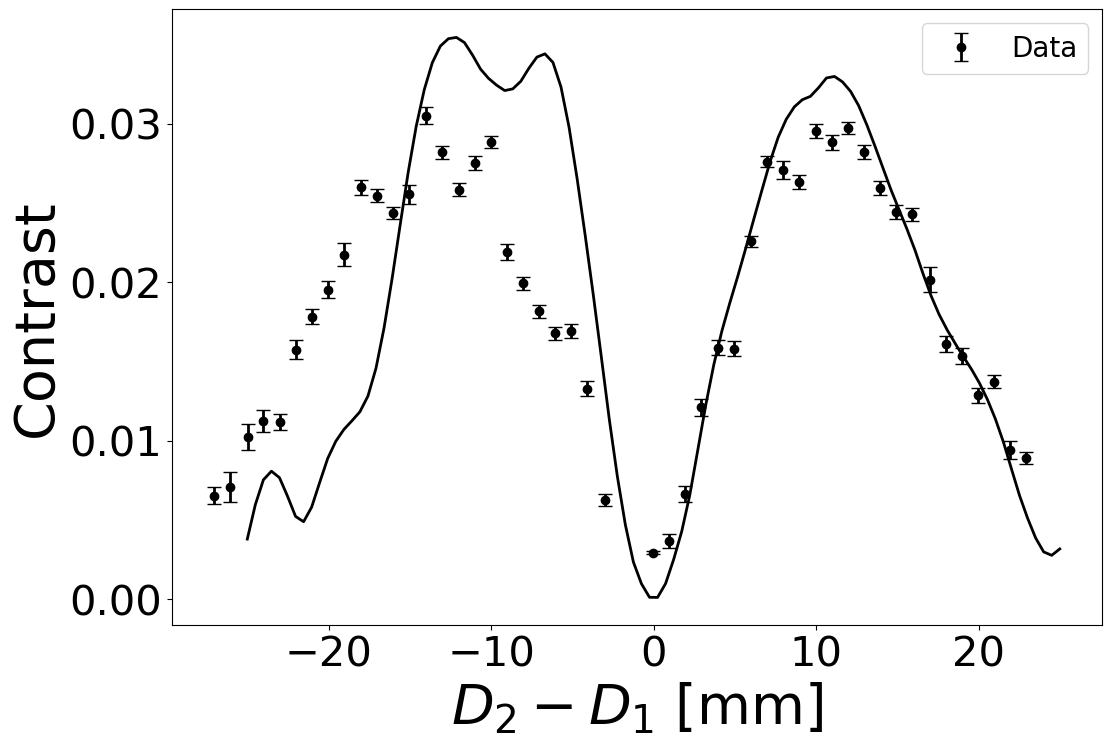

In [310]:
fig, ax1 = plt.subplots(figsize  = (12,8))

# ax1.set_prop_cycle(color = ["blue","red","black"])

# ax1.plot(simideal.d*1e3, monocont1,lw = 3, label = r"Monochromatic, $m_t = 1$")
# ax1.plot(simideal.d*1e3, monocont5,lw = 3, label = r"Monochromatic, $m_t = 5$")




ax1.plot(simideal.d*1e3, simideal.contrast,"k-",lw = 2)
ax1.errorbar(prld,prlcont,yerr=prlconterr, elinewidth=2,capsize = 5,  fmt = "ko", label = "Data")
# ax1.set_ylim(0,0.04)



# ax2 = ax1.twinx()


# ax2.plot(simrect.d[5:-4]*1e3, freq3monorect[5:-4], label = "All Rectangular Gratings")

# ax2.plot(simrect.d[5:-3]*1e3, freq3monorect5[5:-3], label = "All Rectangular Gratings")


# ax2.plot(simbb.d[5:-3]*1e3, freq3bb[5:-3], "b-",  label = "G2 rotated %.2f degrees" % abs(bbdeg))


# ax2.plot(simrect.d*1e3, abs(1/fitparams3rect5[:,2]) / (1000), "o", label = "All Rectangular Gratings")




# ax2.plot(prld,prlfreq, "bo", label = "Experimental Data")


# ax2.plot(simbb.d*1e3, abs(simbb.d / (L*p*1e3)), label = r"$\frac{d}{Lp}$")

# ax1.legend(loc = (0.3185,0.8), fontsize = 15)

ax1.legend(fontsize = 20)



ax1.set_xlabel(r"$D_2 - D_1$ [mm]", fontsize = 40)
ax1.set_ylabel("Contrast", fontsize = 40)

# ax1.set_title("Contrast vs. G2-G3 Separation, %d diffraction order%s" % (mt, "s" if mt > 1 else ""))
ax1.tick_params(labelsize = 30)
# ax2.tick_params(labelsize = 20)


fig.savefig("3PGMIBaseballBatGrating.png", bbox_inches = "tight")

plt.show()
plt.close(fig)